In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from PIL import Image
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/AML_Data_val.zip'
extract_path = '/content/Data'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

def count_folders_in_directory(directory):
    return sum(os.path.isdir(os.path.join(directory, i)) for i in os.listdir(directory))

directory_path = '/content/Data/Data_val/train/Null'
folder_count = count_folders_in_directory(directory_path)

print(f"Number of folders in '{directory_path}': {folder_count}")


Number of folders in '/content/Data/Data_val/train/Null': 909


In [ ]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {'Arm flapping': 0, 'Finger flicking': 1, 'Null': 2}
        self.bunches, self.labels = self._load_bunches()

    def _load_bunches(self):
        bunches, labels = [], []
        for class_name, class_idx in self.classes.items():
            class_dir = os.path.join(self.root_dir, class_name)
            for bunch in os.listdir(class_dir):
                bunch_dir = os.path.join(class_dir, bunch)
                if os.path.isdir(bunch_dir):
                    frames = sorted([os.path.join(bunch_dir, f) for f in os.listdir(bunch_dir) if f.endswith('.jpg')])
                    if len(frames) == 15:
                        bunches.append(frames)
                        labels.append(class_idx)
        return bunches, labels

    def __len__(self):
        return len(self.bunches)

    def __getitem__(self, idx):
        frames = [Image.open(frame) for frame in self.bunches[idx]]
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        label = self.labels[idx]
        return frames, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = VideoDataset(root_dir='/content/Data/Data_val/train', transform=transform)
val_dataset = VideoDataset(root_dir='/content/Data/Data_val/val', transform=transform)
test_dataset = VideoDataset(root_dir='/content/Data/Data_val/test', transform=transform)

In [ ]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        # Load pre-trained ResNet-101
        self.resnet = models.resnet101(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=256, num_layers=3, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.resnet(c_in)
        c_out = c_out.view(batch_size, timesteps, -1)
        lstm_out, _ = self.lstm(c_out)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        total_loss, total_correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / total)
        train_accuracies.append(total_correct / total)

        # Validation
        model.eval()
        with torch.no_grad():
            total_loss, total_correct, total = 0, 0, 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total += labels.size(0)

            val_losses.append(total_loss / total)
            val_accuracy = total_correct / total
            val_accuracies.append(val_accuracy)

            # Save the model if validation accuracy improves
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, '
              f'Train Acc: {train_accuracies[-1]:.4f}, '
              f'Val Acc: {val_accuracies[-1]:.4f}')
        print()

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
num_epochs = 30
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/30
----------
Epoch 1/30, Train Loss: 1.1027, Val Loss: 1.1434, Train Acc: 0.3826, Val Acc: 0.4645

Epoch 2/30
----------
Epoch 2/30, Train Loss: 1.0930, Val Loss: 1.0705, Train Acc: 0.3857, Val Acc: 0.4645

Epoch 3/30
----------
Epoch 3/30, Train Loss: 1.0932, Val Loss: 1.1010, Train Acc: 0.3804, Val Acc: 0.4645

Epoch 4/30
----------
Epoch 4/30, Train Loss: 1.0915, Val Loss: 1.1039, Train Acc: 0.3899, Val Acc: 0.4645

Epoch 5/30
----------
Epoch 5/30, Train Loss: 1.0908, Val Loss: 1.0934, Train Acc: 0.3918, Val Acc: 0.4645

Epoch 6/30
----------
Epoch 6/30, Train Loss: 1.0907, Val Loss: 1.1260, Train Acc: 0.3899, Val Acc: 0.4645

Epoch 7/30
----------
Epoch 7/30, Train Loss: 1.0914, Val Loss: 1.0859, Train Acc: 0.3893, Val Acc: 0.4645

Epoch 8/30
----------
Epoch 8/30, Train Loss: 1.0912, Val Loss: 1.1217, Train Acc: 0.3918, Val Acc: 0.4645

Epoch 9/30
----------
Epoch 9/30, Train Loss: 1.0909, Val Loss: 1.1102, Train Acc: 0.3918, Val Acc: 0.4645

Epoch 10/30
----------
Epoch

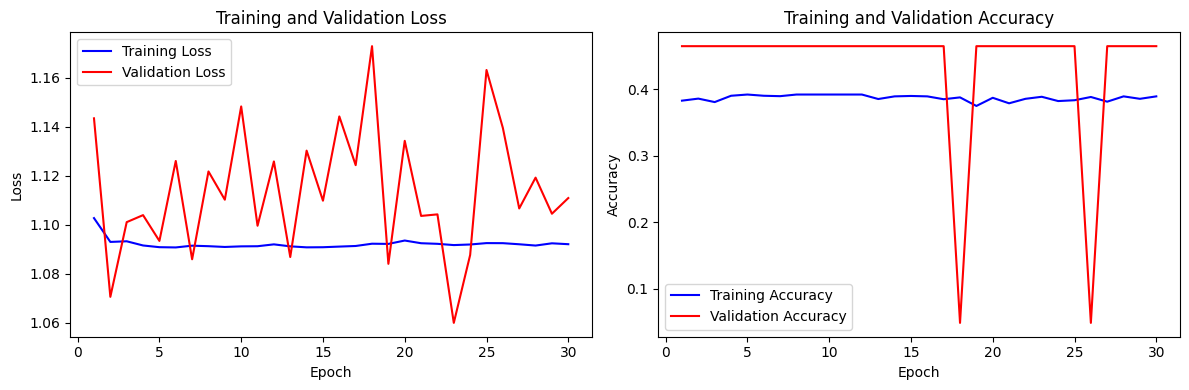

In [ ]:
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

Accuracy on the test set: 24.12%


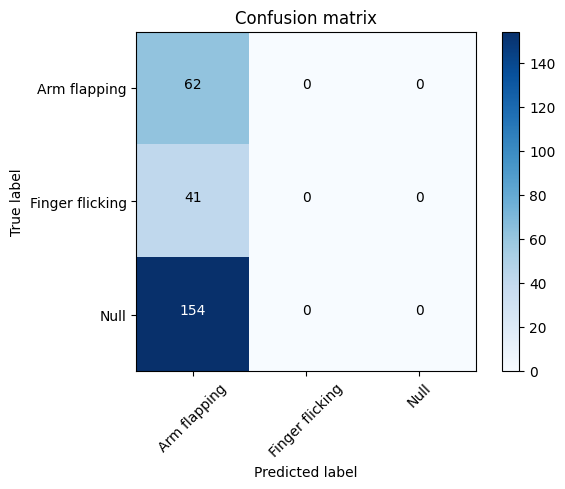

Model training and evaluation complete.


In [ ]:
model.eval()
correct = 0
total = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Accuracy on the test set: {test_accuracy:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['Arm flapping', 'Finger flicking', 'Null'])

print('Model training and evaluation complete.')

In [ ]:
model_path = '/content/drive/My Drive/resnet/3_layer_CE_30_epochs_0.01.pth'
torch.save(model.state_dict(), model_path)